# Week 7: Segmentation

If you have any questions or suggestions about this part, please feel free to contact the teaching assistants Wanying Tao on WeChat.

1. 本次实验过程中，先实现反卷积的计算过程
2. 理解语义分割模型的数据的标签`Ground truth`的特点，体会其与分类网络的区别
3. 探索和训练一个简单的`UNet`网络（重点）
4. 在基础的网络结构之上，增加和修改的部分结构，进一步提升网络性能

首先，配置好我们需要的环境，因为代码比较多，所以我们将会以`Python Package`的形式给你提供大部分的代码。但是如果是普通的更新package的代码的话，需要对每一次更新都进行手动加载，比较麻烦。所幸`jupyter`为我们提供了自动加载的魔术方法，请执行以下代码，设置Python包在Jupyter环境下的自动更新问题。我们每一次对`import`的`package`进行修改的时候，修改的内容都会自动更新到这个环境中。

In [1]:
# This two line are jupyter magical method which use to auto reload the package you changed
%load_ext autoreload
%autoreload 2

由于`PyTorch`版本的更替，在比较新的PyTorch版本环境中运行该代码可能会产生某些弃用函数的warning，在此我们不必要关注这部分的信息，可以将其屏蔽掉：

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import necessary package for the following exercises
from __future__ import division, print_function
#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch

## 利用numpy手动实现反卷积的过程

要了解反卷积的计算过程，我们要先来回顾卷积的实现过程。卷积的运算过程非常的简单，就是卷积核的不断平移和乘加。但是事实上，卷积运算通过卷积核大小的改变、平移的步长、图像边边的补零等一系列的操作，卷积过程的运算种类是非常多的。

各种卷积过程直观显示大礼包[点击这里](https://github.com/vdumoulin/conv_arithmetic)

### 1. 卷积的实现

In [4]:
def convolution( feature_map, kernel ):   
    # h : height of feature_map
    # w : weight of feature_map
    # k : kernal_size
    h, w = feature_map.shape
    k, _ = kernel.shape
    
    # p : padding size in the feature map
    p = int( k/2 )
    
    
    
    # add zeors padding for the input feature map
    feature_map_padding = np.zeros([ h+p*2, w+p*2 ])
    feature_map_padding[ p:h+p, p:w+p ] = feature_map
    
    result = np.zeros([h, w])
    for i in range(h):
        for j in range(w):
            # region of interest
            roi          = feature_map_padding[i:i+k, j:j+k]
            result[i][j] = np.sum( roi * kernel )
    return result

以上只是最简单版本的单通道输入、单通道输出的卷积过程。然而，我们在实际运算的过程中用到的都是多通道输入、多通道输入的卷积。在上述模块的基础上，我们可以很容易地实现多通道输入多通道输入的卷积运算过程。只需要使用两个`for`循环，遍历每一个通道的输入和每一个通道的输出即可。如下所示。

In [5]:
def conv2d( input, weights ):
    # c : channel
    # h : height
    # w : weight
    in_channel, h, w = input.shape
    out_channel, *_  = weights.shape
    
    output = np.zeros( [out_channel, h, w] )
    for i in range(out_channel):
        weight = weights[i]
        for j in range(in_channel):
            feature_map = input[j]
            kernel      = weight[j]
            output[i]  += convolution(feature_map, kernel)
    return output

### 2. 反卷积的实现

在深度学习上，细节的恢复本来是依靠简单的`Upsample`，为了使得细节恢复更加温和，就使用反卷积这种操作。这种操作具体来说指的是如下图所示的一个操作，即：先对输入的矩阵进行插空补零，然后再进行卷积操作，使得输出的矩阵比输入的矩阵更大。**一句话来说就是，卷积的过程使得输出的`Feature map`比输入的`Feature map`在尺寸上更小，在特征表示上更加抽象；而反卷积的过程则是使得输出的`Feature map`比输入的`Feature map`在尺寸上更大，细节更加丰富，特征表示上更加具象，两者的参数均可训练。**详细的介绍可参考这篇文章（点击[这里](https://arxiv.org/pdf/1603.07285.pdf)）,这篇文章总结得很全。

而在反卷积的名字之争的话，则要另开一话了。感兴趣的可以点击[这里](https://www.zhihu.com/question/43609045)阅读原文
>逆卷积相对于卷积在神经网络结构的正向和反向传播中做相反的运算。逆卷积(Deconvolution)比较容易引起误会，转置卷积(Transposed Convolution)是一个更为合适的叫法. 


>Deconv本身其实有标准定义指conv的逆运算，一般通过Fourier Transform求解。深度学习里的deconv其实用错了，不是指逆运算，而是指transposed convolution, backward convolution, fractally strided convolution, upsampling convolution.

在实现上，反卷积操作思路如下：先对输入的矩阵填充0，然后进行卷积，卷积过程跟上述的加Padding的卷积过程一致，最后进行裁剪，使得输出的图像大小是输入的两倍。注意观察，填充0的操作会使得经过卷积之后，原来input的数值在output中不发生改变（红色数字）。如下图所示：

![deconv](resources/deconvolution.PNG)

***********************************************************************************
#### &#9733;&#9733;&#9733; Question 0
请根据你的理解，完成一下反卷积函数，并在接下来的程序中，验证函数实现的正确性。
******************************************************************************

In [28]:
def fill_zeros(input):
    # c : channel
    # h : height
    # w : weight
    c, h, w  = input.shape
    ############################################################
    #write your code here
    
    h_new, w_new = h*2+1, w*2+1
    
    res = np.zeros((c,h_new,w_new))
    for k in range(c):
        for i in range(h):
            for j in range(w):
                res[k,i*2+1,j*2+1] = input[k,i,j]
    
    ############################################################
    return res

In [41]:
def deconv2d( input, weights ):
    # input.shape is ( channel, height, weight )
    _, input_h, input_w = input.shape
    out_h = input_h*2
    out_w = input_w*2
    
    ############################################################
    # write your code here
    # fill zeros
    res = fill_zeros(input)
    
    # conv2d
    res = conv2d(res, weights)
    
    # crop
#     print(weights.shape)
#     print(out_h,out_w)
    res = res[:,1:out_h,1:out_w] 
    
    #############################################################

    return res

In [22]:
input_data=[
               [[1,0,1],
                [0,2,1],
                [1,1,0]],

               [[2,0,2],
                [0,1,0],
                [1,0,0]],

               [[1,1,1],
                [2,2,0],
                [1,1,1]],

               [[1,1,2],
                [1,0,1],
                [0,2,2]]

            ]

weights_data=[ 
              [[[ 1, 0, 1],
                [-1, 1, 0],
                [ 0,-1, 0]],
               [[-1, 0, 1],
                [ 0, 0, 1],
                [ 1, 1, 1]],
               [[ 0, 1, 1],
                [ 2, 0, 1],
                [ 1, 2, 1]], 
               [[ 1, 1, 1],
                [ 0, 2, 1],
                [ 1, 0, 1]]],
    
              [[[ 1, 0, 2],
                [-2, 1, 1],
                [ 1,-1, 0]],
               [[-1, 0, 1],
                [-1, 2, 1],
                [ 1, 1, 1]],
               [[ 0, 0, 0],
                [ 2, 2, 1],
                [ 1,-1, 1]], 
               [[ 2, 1, 1],
                [ 0,-1, 1],
                [ 1, 1, 1]]]  
           ]

In [42]:
input   = np.array( input_data  )
weights = np.array( weights_data )
print( deconv2d(input, weights) )

[[[ 3.  3.  2.  7.  5.]
  [ 6.  8.  5. 11.  2.]
  [ 2.  7.  2.  3.  3.]
  [ 5. 11.  3.  9.  3.]
  [ 1.  4.  5.  4.  4.]]

 [[ 6.  0.  1.  8.  5.]
  [ 0.  8. -2. 14.  2.]
  [ 3.  9.  8.  1.  0.]
  [ 0. 13.  0. 11.  2.]
  [ 5.  3.  1.  3.  0.]]]


以下代码作为验证程序正确性使用，不作理解要求，即将`Pytorch`中的一个的反卷积操作当做一个迷你的网络来使用即可。

请使用以下Pytorch反卷积代码验证你的结果。

In [30]:
input         = torch.tensor(input_data).unsqueeze(0).float()

torch_deconv2d  = torch.nn.ConvTranspose2d( in_channels=4, \
            out_channels=2, kernel_size=3, padding = 1, stride=2)

state = torch_deconv2d.state_dict()
weights = np.rot90(np.array(weights_data), 2, axes=(2,3)).copy()

#weights = np.array(weights_data)
state["weight"] = torch.from_numpy(weights).float().transpose(1, 0)
state["bias"]   = torch.zeros(torch.Size([2]))
torch_deconv2d.load_state_dict(state)
print(torch_deconv2d(input))

tensor([[[[ 3.,  3.,  2.,  7.,  5.],
          [ 6.,  8.,  5., 11.,  2.],
          [ 2.,  7.,  2.,  3.,  3.],
          [ 5., 11.,  3.,  9.,  3.],
          [ 1.,  4.,  5.,  4.,  4.]],

         [[ 6.,  0.,  1.,  8.,  5.],
          [ 0.,  8., -2., 14.,  2.],
          [ 3.,  9.,  8.,  1.,  0.],
          [ 0., 13.,  0., 11.,  2.],
          [ 5.,  3.,  1.,  3.,  0.]]]], grad_fn=<SlowConvTranspose2DBackward>)


## 1. 数据准备和探索

### 1.1 数据集的产生

从`image_utils`文件夹中引入数据生成器。我们不太需要理解数据生成的过程，只需要观察生成好的图片数据即可。观察和分析数据集通常是我们的第一步，通过观察数据集的特点，可以进一步决定我们训练数据所需要选择的模型和训练的方式。请依次执行以下部分的代码：

In [4]:
# get the image generator
from image_utils import image_gen

通过导入的`image_gen`，构造一个带分割标签（`Ground truth`）的、超级精确的图片生成器。其中，变量`nx`和`ny`分别表示所生成的图片的长和宽，通过这两个参数，可以控制生成器生成图片的大小，一般要求是生成2的N次方(否则容易产生bug，具体原因是`downsample`的时候，产生的小数被抹除，而`upsample`的时候不能准确恢复被抹除的小数部分)，`cnt`表示的是前景部分的需要分割出来的物体的个数,`sigma`表示添加噪音的强烈程度，sigma越小，噪音越弱，训练越简单，在下面的练习中可以看到。请执行以下部分代码（可根据自己的需求修改以上三个参数）：

In [11]:
# You can change the nx and ny to change the image size
nx  = 128
ny  = 128
cnt = 10
# sigma param is used to control the noise strength
generator = image_gen.GrayScaleDataProvider(nx, ny, cnt=cnt, sigma=20)
#generator = image_gen.RgbDataProvider(nx, ny）

#### Note 1
由于分割网络的代码参数量比较大，为了尽量降低实验过程对电脑设备和`GPU`显存大小的要求，在本次实验过程中，我们并没有使用语义分割最常用的数据集，例如`VOC`， `CoCo`等多分类语义分割数据集。而是选择了我们人为构造的几何形状作为数据集，可以通过手动调节参数的方式，任意指定训练输入图片的大小，手动降低实验数据的数据量和对电脑内存（显存）资源的要求。这样子的__好处__在于即使个人PC没有GPU资源，我们也可以训练好整个网络，让大家对语义分割模型有直观地感受。__不好的地方__在于这个数据集非常简单，很多的`Tricks`或模型的改进，对性能的提升在这里可能体现得不明显。

### 1.2 观察数据集

我们在训练数据之前必须要对其进行充分的观察和分析，了解这个数据集的具体内容和相应的特点，清楚其难点在哪里，哪些部分的数据很具有挑战性，这些都可以增强我们对这个任务直观、感性的认识。

所以，现在我们可以来探索一下`generator`做了些什么，为我们提供了怎么样的数据。查看生成数据的维度是一个非常直观且重要的观察方式，在我们自己编写模型的时候，模型`input`的维度要与`generator`的符合，请执行以下代码：

In [12]:
# "2" means how many images you want to get
x_test, y_test = generator(2)
print(x_test.shape)
print(y_test.shape)

(2, 128, 128, 1)
(2, 128, 128, 2)


**************************************************************************
####  &#9733;&#9733;&#9733; Question 1 :
从上面的输出可以看出，这里面得到的数据格式是`B*H*W*C`，还是`B*C*H*W`？是否可以看出得到的图片是灰度图像还是RGB图像？为什么？   
【tips】B = batchsize, C = channel, H = height, W = width. 此前的课件中，`dataloader`函数中已经给大家安排好了输入数据的维度的问题，PyTorch为代表的框架使用`B×C×H×W`的形式，Tensorflow为代表的框架是用`B×H×W×C`的形式。在实际的网络训练过程中，我们需要自己处理好输入数据的维度的问题。这在接下来的代码中也有体现。

Answer 1：（双击此处输入答案）
BHWC，灰度图，因`x_test`通道数为1

***********************************************************************

将数据可视化成图片显示出来，观察视觉效果，请执行以下代码：

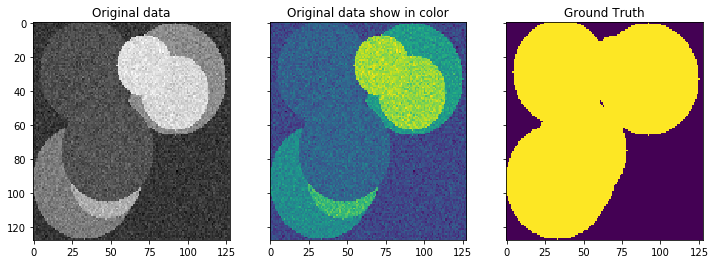

In [46]:
x_test, y_test = generator(2)
fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,4))
ax[0].set_title("Original data")
ax[1].set_title("Original data show in color")
ax[2].set_title("Ground Truth")
ax[0].imshow(x_test[0,...,0], aspect="auto",  cmap="gray" )
ax[1].imshow(x_test[0,...,0], aspect="auto")
ax[2].imshow(y_test[0,...,1], aspect="auto")

*上面共产生了三幅图像，其中第一幅显示的是数据的原图，第二幅图像是`matplotlib`在可视化灰度图像的时候，为了增加图像的对比度，默认将其转换成`RGB`图像输出，第三幅图像显示的是该图像对应的分割的标签，也就是Ground Truth。由此可见，该`generator`生成的图片是一对一对生成的，生成训练图像的同时，也生成了该图像的标签。*

## 2. 基本的语义分割模型--UNet

准备好训练的数据之后，我们就可以开始构建我们的训练模型了。首先先来回顾一下`UNet`的网络结构   
![u-net-architecture](resources/u-net-architecture.png)


 *Architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations.*


### 2.1 网络的搭建

网络搭建过程的代码位于同文件夹中的`unet`文件夹下面。文件的路径为`./unet/unet_parts.py`和`./unet/unet_model.py`，直接点开该文件夹下的`Python`文件阅读代码并补全`unet_model.py`中的UNet部分，了解网络搭建的过程，以下所有文件的位置，均以上述相对路径的形式指明，不加赘述。

在搭建网络的时候，注意体会代码中分模块搭建的过程。比如，注意观察上面的`UNet`网络结构，在特征提取部分（代码`unet_part.py`中的`down`类）都是两次卷积加一次maxpool的过程；在细节恢复部分（代码`unet_part.py`中的`up`类）都是先级联上一次的特征图，然后再进行两次卷积。由于整个网络都是严格对称的，所以代码非常简单，可以很工整地使用模块化的编程思想，有助于对这部分代码的理解。

### 2.2 训练网络

将网络模型导入到内存中。请执行以下代码：

In [6]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from unet import UNet
from unet import eval_net

检查设备中是否带有GPU，如果有的话，恭喜你，模型的训练速度是仅仅使用CPU进行训练无法企及的。该变量在接下来的实验中会被反复用到，来决定使用CPU还是GPU。请执行以下代码：

In [2]:
is_cuda = True if torch.cuda.is_available() else False
print(is_cuda)

True


如果是使用GPU的话，我们还可以通过以下代码来查看我们当前使用的设备, 没有GPU的时候执行以下代码就会报错，可以不必理会。

In [49]:
print( torch.cuda.current_device()  ) # which GPU you're using
print( torch.cuda.device_count()    ) # how many GPU you have
print( torch.cuda.get_device_name(0)) # device name

0
1
GeForce GTX 1050


**自行手动更改当前使用的GPU的命令如下所示（学会自己指定空闲的GPU进行使用）：**

In [51]:
id = 0
torch.cuda.set_device(id)
print( torch.cuda.current_device() )

0


言归正传，我们需要新建一个网络的对象，定义loss函数和优化器，这里使用二分类的binary_cross_entropy。请执行以下代码：

In [3]:
# Initialize a basic UNet
unet = UNet(n_channels=1, n_classes=2)
# Define a binary Corss entropy loss, the most common loss
criterion = nn.BCELoss()     
# Define an optimizer, specific way to update the parameters in your network
optimizer = optim.SGD( unet. parameters(),
                       lr           = 0.001,
                       momentum     = 0.9,
                       weight_decay = 0.0005
                     )

# Does your PC have a GPU? If yes, use it
if is_cuda:
    unet = unet.cuda()

至此，我们已经正式准备好了数据，网络结构，loss函数，以及参数更新所使用的优化器，万事具备，只欠训练了。

#### Note 2 
这一部分处理的代码，由于为了简化使用虚拟数据而非真实数据，所以不需要进行繁琐的数据取拿操作，不需要考虑经过多少个step之后得到一个epoch等问题。但是在处理真实数据的时候，这些内容还是需要我们去关注。
在这里只需要给这些参数填上一个差不多的数字即可，生成器就会按照我们的需要提供相应的数据。

下面代码中的`steps`变量表示每个epoch中网络迭代的次数，部分代码中也记作__`iterations`__，一个__`step`__，也就是一个__`iteration`__。__`batch_size`__指的是每个__`iteration`__中的__`minibatch`__中图像的数量。请理解和执行以下部分代码。

In [10]:
epochs     = 5         # usual value is 50, 100, 150
steps      = 50        # usual value is ？ No usual value, just go through the whole training set
batch_size = 4         # usual value is 16， 32， 64, usually as big as possible
# valid_size = 50        # No usual value, just 20% of the whole dataset

epoch_loss = 0

# used to plot the loss during training，counter is used to count the Number of iterations
curr_step  = np.zeros( epochs*steps )
step_loss  = np.zeros( epochs*steps )
counter    = 0
for epoch in range(epochs):
    for step in range(steps):
        batch_x, batch_y = generator(batch_size)
        
        # Remember the different between B*H*W*C (tensorflow) and B*C*H*W (pytorch, caffe)
        # we should change a batch of rgb images into correct index
        batch_x = np.transpose( batch_x, axes=[0, 3, 1, 2] ).astype(np.float32)
        batch_y = np.transpose( batch_y, axes=[0, 3, 1, 2] ).astype(np.float32)
        
        # from numpy object to torch tensor object
        batch_x = torch.from_numpy( batch_x )
        batch_y = torch.from_numpy( batch_y )
        
        if is_cuda:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        
        # Attention: You Should Understand what these three lines mean
        # masks_pred: the ouput of unet in forward process, the unber could be very large
        # masks_probs: regularize the output of the network
        masks_pred       = unet(batch_x)
        masks_probs      = F.sigmoid(masks_pred)
        masks_probs_flat = masks_probs.reshape(-1)

        
        batch_y_flat     = batch_y.reshape(-1)
        loss             = criterion( masks_probs_flat, batch_y_flat)
        
        # this record is used to plot the curve
        curr_step[ counter ] = epoch*steps + step
        step_loss[ counter ] = loss.item()
        counter += 1
        
        # track the loss
        if (step+1) % 10==0:
            print("epoch {0:} iteration {1:} loss is {2:0.4f}".format(epoch+1, step+1, loss.item()) )
            
        # update all parameters in the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    val_score = eval_net( unet, generator, gpu=is_cuda, num_validation=2 )
    print("validation dice coeff: {}".format( val_score) )

D:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 1 iteration 10 loss is 0.5363
epoch 1 iteration 20 loss is 0.4090
epoch 1 iteration 30 loss is 0.3158
epoch 1 iteration 40 loss is 0.2647
epoch 1 iteration 50 loss is 0.2551
validation dice coeff: 0.9673102796077728
epoch 2 iteration 10 loss is 0.2491
epoch 2 iteration 20 loss is 0.2380
epoch 2 iteration 30 loss is 0.2596
epoch 2 iteration 40 loss is 0.0966
epoch 2 iteration 50 loss is 0.4007
validation dice coeff: 0.9057452380657196
epoch 3 iteration 10 loss is 0.1388
epoch 3 iteration 20 loss is 0.1791
epoch 3 iteration 30 loss is 0.7043
epoch 3 iteration 40 loss is 0.1666
epoch 3 iteration 50 loss is 0.1098
validation dice coeff: 0.910121887922287
epoch 4 iteration 10 loss is 0.1196
epoch 4 iteration 20 loss is 0.2194
epoch 4 iteration 30 loss is 0.3410
epoch 4 iteration 40 loss is 0.1394
epoch 4 iteration 50 loss is 0.1354
validation dice coeff: 0.9819775223731995
epoch 5 iteration 10 loss is 0.3421
epoch 5 iteration 20 loss is 0.0867
epoch 5 iteration 30 loss is 0.0877
epoch

### 2.3 记录实验过程

************************************************************************
#### &#9733;&#9733;&#9733; Question 2:
画出训练过程中loss的变化曲线，请在下方补全代码。

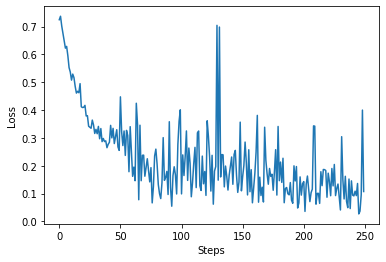

In [13]:
# code here
# Hint: Use matplotlib.pyplot to plot the curve
# write your code here
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.plot(step_loss)
plt.show()

*************************************************************************************

### 2.4 模型的评估方式

常用的分割效果评估方式有两种，一种是计算`Jaccard`值，一种是计算`Dice`值。两者比较类似，单调性相同，可以相互转换，但是数值性质有细微的不一样。下面会对此进行简单的回顾和说明。   

值得注意的是（细心的你可能自己已经注意到了），我们在训练神经网络的时候，使用了`Binary Cross Entropy`，而在评估模型好坏的时候，使用的并不是每一个像素点的分类准确度百分比（之前训练分类网络的时候，使用的是每一类的分类的准确度来评估模型的结果，那么这里对应的做法应该是计算每一个像素点的分类的准确度），这是为什么呢？ 这种损失函数与评估函数之间的差别，会给我们的训练带来什么不好的影响呢？

#### 2.4.1 Jaccard值的理解
现在你只需要意识到这样的问题存在，然后我们不妨先来回顾下[`Jaccard`](https://zh.wikipedia.org/wiki/%E9%9B%85%E5%8D%A1%E5%B0%94%E6%8C%87%E6%95%B0)值。
>雅卡尔指数（英语：Jaccard index），又称为并交比（Intersection over Union）、雅卡尔相似系数（Jaccard similarity coefficient），是用于比较样本集的相似性与多样性的统计量。雅卡尔系数能够量度有限样本集合的相似度，其定义为两个集合交集大小与并集大小之间的比例：
>$$J(A,B) = {{|A \cap B|}\over{|A \cup B|}} = {{|A \cap B|}\over{|A| + |B| - |A \cap B|}}.$$ 
>如果A与B完全重合，则定义J(A,B) = 1。于是有:
>$$0\le J(A,B)\le 1.$$

直观理解如下两图所示：

![Intersection](resources/1280px-Intersection_of_sets_A_and_B.svg.png)
![Union](resources/1280px-Union_of_sets_A_and_B.svg.png)

*`Jaccard`值等于上子图的紫色部分和下子图的紫色部分的比值。在离散的像素图像中表现为：上下两图的紫色部分的像素点个数的比值（这也是我们在计算的时候使用的方法）。*

#### 2.4.2 `Dice`值的理解

有了上面`Jaccard`值的铺垫，[`Dice`](https://zh.wikipedia.org/wiki/Dice%E7%B3%BB%E6%95%B0)值就非常容易理解了:   
>Dice系数, 根据 Lee Raymond Dice 命名，是一种集合相似度度量函数，通常用于计算两个样本的相似度：
$$s = \frac{2 | X \cap Y |}{| X | + | Y |}$$
它和Sørensen 相似度指数相同, 也称作Sørensen-Dice系数。 它在形式上和Jaccard指数没多大区别，但是有些不同的性质。
和Jaccard类似，它的范围为0到1。   



**********************************************************************************************
#### &#9733;&#9733;&#9733; Question 3：
请结合对`Jaccard`值的理解，根据`Jaccard`值的计算公式，补充好`./unet/dice_loss.py`中`JaccardCoeff`类的内容，使其能够正确计算出预测结果的`Jaccard`值。**然后执行以下代码进行测试和比较，观察你的输出结果是否正确**。   
【tips】参考和借鉴同文件中`DiceCoeff`类的实现方法

【tips】只需要按指示完成`forward`函数即可，不需要写`backward`函数

In [21]:
#from unet import dice_coeff as dice
from unet import JaccardCoeff as jaccard


# get three 2D matrix as inputs
eye   = torch.tensor(np.eye(3)       )
ones  = torch.tensor(np.ones([3, 3]) )
zeros = torch.tensor(np.zeros([3,3]) )

# show the input
print( eye  )
print( ones )
print( zeros)

# get your result
print( jaccard().forward(eye,   eye) )  
print( jaccard().forward(eye,   ones) )
print( jaccard().forward(zeros, ones) )
print( jaccard().forward(zeros, zeros))

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=torch.float64)
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)
tensor(1.)
tensor(0.3333)
tensor(1.1111e-05)
tensor(1.)


其结果如下图所示：

``` Python  
tensor([[ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]], dtype=torch.float64)
tensor([[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]], dtype=torch.float64)
tensor([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]], dtype=torch.float64)
tensor(1.0000)
tensor(0.3333)
tensor(1.00000e-05 *
       1.1111)
tensor(1.)
```

【Tips】回顾`Dice`值的计算公式，考虑两张图像中每一个像素点均为0的情况，此时分母为0，计算没有意义。因此，我们需要在计算的时候给分子和分母加上平滑项`eps`，使得计算具有意义，`eps`取极小值，避免对非零值计算的时候产生太大的误差。
*************************************************************************************************

#### 2.4.3 拓展理解——为什么要使用Jaccard和Dice来评估模型

也就是回答上面提到的问题，为什么我们在训练神经网络的时候，使用了`Binary Cross Entropy`，而在评估模型好坏的时候使用Jaccard和Dice值。在此引用国外的一篇优秀博文进行理解，同学们可以点击[这里](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)阅读原文并利用课后时间回答。  

Answer：（双击此处输入答案）
因为在实例分割/目标检测任务中，边界框往往不能跟ground-truth**完全重合**，在预测过程中总会有偏差，因此只需保证边界框与真实边框的距离尽可能小，或说重叠部分尽可能大即可，如下图所示。
![](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_examples.png)

### 2.5 观测和分析实验结果

**********************************************************************************************
#### &#9733;&#9733;&#9733; Question 4
在分割模型中，如何通过卷积神经网络得到预测结果？请阅读并执行以下代码，然后进行简要分析。    
【Tips】网络输出的是一个很大的数值，然后使用`sigmoid`函数可以将网络输出归一化到0-1之间的数值，使得各个像素点的概率可比较。语义分割网络输出的`channel`数为前景数目加上背景数目，一般第0个`channel`输出的是每个像素点对应被判别为背景的概率，第1个`channel`输出的每个像素点对应的判别第一类物体的概率。VOC数据集需要对20类物体进行分割，加上背景类，网络输出的`channel`数为21，本次实验中仅对1类物体进行分割，网络输出的`channel`数为2.
【Tips】可以先阅读和执行下面的代码再来回答此问题

Answer 4：（双击此处输入答案）
网络输出结果先通过sigmoid函数，使其值范围归为0到1。对于此例，由于只有两个类别（前景和背景），因此可以直接以0.5为分界线，0.5以上是前景，0.5以下是背景，此即阈值法。对于n个类别，则可以将[0,1]区间等分为n份，落到哪一个区间就属于哪一个类别。

***********************************************************************************

根据自己的思考，理解以下代码，运行并观察实验结果。

In [22]:
def predict(network, image, grounth_truth ):
    
    # By default all the modules are initialized to 
    # train mode (self.training = True). Also be aware 
    # that some layers have different behavior during training 
    # and evaluation (like BatchNorm, Dropout)
    # so we should change the mode
    network.eval()
    
    # be aware of the B×H×W×C and the B×C×H×W
    image = np.transpose( image, axes=[0, 3, 1, 2] ).astype(np.float32)
    
    # prepare the input datatype
    image_input = torch.from_numpy(image)
    image_input = image_input.cuda() if is_cuda else image_input

    # get the network output, and then regular each pixel between 0 and 1
    masks_pred = network(   image_input )
    masks_prob = F.sigmoid( masks_pred  )
    
    # get numpy object result from torch.tensor
    if is_cuda:
        masks_prob = masks_prob.cpu().data.numpy()
    else:
        masks_prob = masks_prob.data.numpy()
    
    masks_binary = masks_prob.copy()
    
    # if the prossibility is greater than 0.5, we mask it as 1
    # if the prossibility is less then 0.5, we mask it as 0
    masks_binary[ masks_binary>=0.5 ] = 1
    masks_binary[ masks_binary< 0.5 ] = 0
    # predication is finished！
    
    # show me the result
    fig, axs = plt.subplots(2,2, sharey=True, figsize=(10,8))
    axs[0][0].set_title("Original data show in color")
    axs[0][1].set_title("Ground Truth")
    axs[1][0].set_title("Probility heatmap")
    axs[1][1].set_title("Predition")
    
    ax00 = axs[0][0].imshow( image[0,0,...],        aspect="auto" )
    ax01 = axs[0][1].imshow( ground_truth[0,...,1], aspect="auto" )
    ax10 = axs[1][0].imshow( masks_prob[0,1,...],   aspect="auto", cmap="hot" )
    ax11 = axs[1][1].imshow( masks_binary[0,1,...], aspect="auto" )
    
    fig.colorbar(ax00, ax=axs[0][0])
    fig.colorbar(ax01, ax=axs[0][1])
    fig.colorbar(ax10, ax=axs[1][0])
    fig.colorbar(ax11, ax=axs[1][1])
        

有了训练好的模型以及预测函数，我们就可以拿图片生成器来生成一些新的图片进行测试了，请重复多次执行以下面框中的代码，观察不同的图片的预测结果。

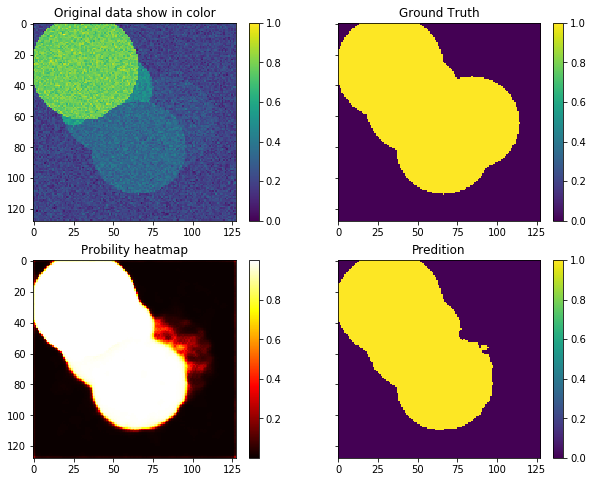

In [26]:
input, ground_truth = generator(1)
predict(unet, input, ground_truth)

*上图中左上角的子图是输入到UNet中的图片；右上角的子图是输入图片的标签，即分割的Ground Truth；左下角的子图是每个像素点的概率图，颜色越亮，概率越大，这个子图的图片也就是上面方框中第19行的输出值；右下角的子图是网络的预测值，也就是将左下角的子图以0.5为阈值，上下取整后输出的图像。*

********************************************************************************************************
#### &#9733;&#9733;&#9733; Question 5
反复执行上述代码，找出一张预测结果不好的图片，并且分析为什么该图片的预测结果会比较糟糕？

Answer 5：（双击此处输入答案）
![](resources/badpic.png)
这幅图中右侧的那个圆形没有被检测出来，因为它太暗了，以至于UNet认为它是背景的一部分。这很大程度上也跟我们简单粗暴的阈值法有关，因为很有可能0.5以下但还不那么接近0的部分依然属于前景。

**********************************************************************************************

## 3. 修改网络模型

简单地修改网络结构，如网络的深度，使得网络变深或者变浅，体会网络的深度对分割模型的影响；又比如将__`upsample`__过程中的浅层特征的__`concate`__修改成__`add`__，体会不同操作对实验结果的影响。


### 3.1 降低网络的层数

网络的深度对网络的性能产生着至关重要的影响。一般来说，网络越深，描述能力越强，性能越高。但是，也会带来梯度消失、梯度爆炸等一系列的问题，使得网络训练更加困难。在本次实验中，要求练习降低网络的层数，目的是让大家更加熟悉UNet的结构。

### 3.2 将`concat`操作与`add`操作进行比较

卷积神经网络在进行特征提取的过程中，具有很强的平移不变性，即不管关键特征位于图像的上下左右各种不同位置，卷积神经网络的特征提取部分都能够很好提取出这部分特征。但是这个特点却会使得网络提取出来的特征丧失掉大部分的空间位置特征。平移不变性在分类器的应用中自然是很好的一个特点，但是却不利于语义分割的细节恢复。这是因为在特征提取过程中提取出来的高维特征已经丢失了大部分的位置信息，而语义分割的过程不仅需要去除背景、恢复图像的关键特征，还需要将图像的关键特征在其原本的位置标注出来。

因此，为了恢复图像的位置信息，语义分割模型就需要在图像细节恢复的过程中（`decoder`过程）将低层的特征图与高层的特征图结合起来，为细节恢复的过程提供足够的位置信息。通常，这有两种操作方式，第一种是以FCN为代表的做法，那就是将浅层特征矩阵与高层特征矩阵相加（`add`）；第二种就是类似于`UNet`的做法，浅层的特征矩阵与高层的特征矩阵级联起来（`concate`）。
课外阅读：https://www.zhihu.com/question/306213462/answer/562776112

********************************************************************************************
#### &#9733;&#9733;&#9733; Question 6
1、原始的Unet结构一共有5层（根据上述提供的模型结构从上往下数），downsample操作执行了4次，对应部分的代码位于`./unet/unet_model.py`文件中。现根据已提供的代码，按照要求，使得Unet模型变浅，模型训练好后观察实验结果。在__`./unet/unet_model.py`__文件中创建一个新的类，命名为__`UNet_shallow`__,要求只__`downsample`__两次，共三层，请参考`Unet`类的写法。   

2、将`UNet`中的`concate`结构修改成`add`的结构，并且将这种新的结构构建一个新的`UNet`命名为`UNet_add`,训练`UNet_add`。

 请先在`./unet/unet_part.py`中参考`up`类的代码（使用的是`concat`方法），将`up_add`类补充完整；   
 然后在`./unet/unet_model.py`中将`Unet_add`类的`forward`函数补充完整，完成`Unet_add`这个网络的训练过程。     
【tips】将`concate`的操作替换成`add`的操作会带来网络传递过程中维度的改变，也就是`decoder`部分，注意体会这部分卷积核参数的变化。

****************************************************************************************

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from image_utils import image_gen
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from unet import UNet_shallow
from unet import eval_net
nx  = 128
ny  = 128
cnt = 10
# sigma param is used to control the noise strength
generator = image_gen.GrayScaleDataProvider(nx, ny, cnt=cnt, sigma=20)

unet_shallow = UNet_shallow(n_channels=1, n_classes=2)
# Define a binary Corss entropy loss, the most common loss
criterion = nn.BCELoss()     
# Define an optimizer, specific way to update the parameters in your network
optimizer = optim.SGD( unet_shallow. parameters(),
                       lr           = 0.001,
                       momentum     = 0.9,
                       weight_decay = 0.0005
                     )

is_cuda = torch.cuda.is_available()
# Does your PC have a GPU? If yes, use it
if is_cuda:
    unet_shallow = unet_shallow.cuda()
    
epochs     = 5         # usual value is 50, 100, 150
steps      = 50        # usual value is ？ No usual value, just go through the whole training set
batch_size = 4         # usual value is 16， 32， 64, usually as big as possible
# valid_size = 50        # No usual value, just 20% of the whole dataset

epoch_loss = 0

# used to plot the loss during training，counter is used to count the Number of iterations
curr_step  = np.zeros( epochs*steps )
step_loss  = np.zeros( epochs*steps )
counter    = 0
for epoch in range(epochs):
    for step in range(steps):
        batch_x, batch_y = generator(batch_size)
        
        # Remember the different between B*H*W*C (tensorflow) and B*C*H*W (pytorch, caffe)
        # we should change a batch of rgb images into correct index
        batch_x = np.transpose( batch_x, axes=[0, 3, 1, 2] ).astype(np.float32)
        batch_y = np.transpose( batch_y, axes=[0, 3, 1, 2] ).astype(np.float32)
        
        # from numpy object to torch tensor object
        batch_x = torch.from_numpy( batch_x )
        batch_y = torch.from_numpy( batch_y )
        
        if is_cuda:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        
        # Attention: You Should Understand what these three lines mean
        # masks_pred: the ouput of unet in forward process, the unber could be very large
        # masks_probs: regularize the output of the network
        masks_pred       = unet_shallow(batch_x)
        masks_probs      = F.sigmoid(masks_pred)
        masks_probs_flat = masks_probs.reshape(-1)

        
        batch_y_flat     = batch_y.reshape(-1)
        loss             = criterion( masks_probs_flat, batch_y_flat)
        
        # this record is used to plot the curve
        curr_step[ counter ] = epoch*steps + step
        step_loss[ counter ] = loss.item()
        counter += 1
        
        # track the loss
        if (step+1) % 10==0:
            print("epoch {0:} iteration {1:} loss is {2:0.4f}".format(epoch+1, step+1, loss.item()) )
            
        # update all parameters in the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    val_score = eval_net( unet_shallow, generator, gpu=is_cuda, num_validation=2 )
    print("validation dice coeff: {}".format( val_score) )

D:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 1 iteration 10 loss is 0.5633
epoch 1 iteration 20 loss is 0.4521
epoch 1 iteration 30 loss is 0.3756
epoch 1 iteration 40 loss is 0.3397
epoch 1 iteration 50 loss is 0.3314
validation dice coeff: 0.956672340631485
epoch 2 iteration 10 loss is 0.3694
epoch 2 iteration 20 loss is 0.1621
epoch 2 iteration 30 loss is 0.2691
epoch 2 iteration 40 loss is 0.0762
epoch 2 iteration 50 loss is 0.2032
validation dice coeff: 0.8989269137382507
epoch 3 iteration 10 loss is 0.1056
epoch 3 iteration 20 loss is 0.1661
epoch 3 iteration 30 loss is 0.1265
epoch 3 iteration 40 loss is 0.1861
epoch 3 iteration 50 loss is 0.4146
validation dice coeff: 0.9712848365306854
epoch 4 iteration 10 loss is 0.3030
epoch 4 iteration 20 loss is 0.1988
epoch 4 iteration 30 loss is 0.1321
epoch 4 iteration 40 loss is 0.2646
epoch 4 iteration 50 loss is 0.3558
validation dice coeff: 0.8866097033023834
epoch 5 iteration 10 loss is 0.1047
epoch 5 iteration 20 loss is 0.0825
epoch 5 iteration 30 loss is 0.0873
epoch

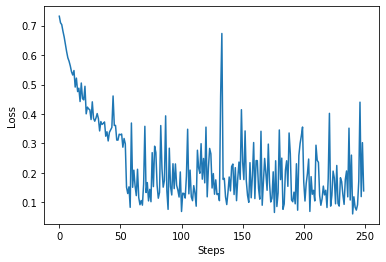

In [2]:
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.plot(step_loss)
plt.show()

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from image_utils import image_gen
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from unet import UNet_add
from unet import eval_net
nx  = 128
ny  = 128
cnt = 10
# sigma param is used to control the noise strength
generator = image_gen.GrayScaleDataProvider(nx, ny, cnt=cnt, sigma=20)

unet_add = UNet_add(n_channels=1, n_classes=2)
# Define a binary Corss entropy loss, the most common loss
criterion = nn.BCELoss()     
# Define an optimizer, specific way to update the parameters in your network
optimizer = optim.SGD( unet_add. parameters(),
                       lr           = 0.001,
                       momentum     = 0.9,
                       weight_decay = 0.0005
                     )

is_cuda = torch.cuda.is_available()
# Does your PC have a GPU? If yes, use it
if is_cuda:
    unet_add = unet_add.cuda()
    
epochs     = 5         # usual value is 50, 100, 150
steps      = 50        # usual value is ？ No usual value, just go through the whole training set
batch_size = 4         # usual value is 16， 32， 64, usually as big as possible
# valid_size = 50        # No usual value, just 20% of the whole dataset

epoch_loss = 0

# used to plot the loss during training，counter is used to count the Number of iterations
curr_step  = np.zeros( epochs*steps )
step_loss  = np.zeros( epochs*steps )
counter    = 0
for epoch in range(epochs):
    for step in range(steps):
        batch_x, batch_y = generator(batch_size)
        
        # Remember the different between B*H*W*C (tensorflow) and B*C*H*W (pytorch, caffe)
        # we should change a batch of rgb images into correct index
        batch_x = np.transpose( batch_x, axes=[0, 3, 1, 2] ).astype(np.float32)
        batch_y = np.transpose( batch_y, axes=[0, 3, 1, 2] ).astype(np.float32)
        
        # from numpy object to torch tensor object
        batch_x = torch.from_numpy( batch_x )
        batch_y = torch.from_numpy( batch_y )
        
        if is_cuda:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        
        # Attention: You Should Understand what these three lines mean
        # masks_pred: the ouput of unet in forward process, the unber could be very large
        # masks_probs: regularize the output of the network
        masks_pred       = unet_add(batch_x)
        masks_probs      = F.sigmoid(masks_pred)
        masks_probs_flat = masks_probs.reshape(-1)

        
        batch_y_flat     = batch_y.reshape(-1)
        loss             = criterion( masks_probs_flat, batch_y_flat)
        
        # this record is used to plot the curve
        curr_step[ counter ] = epoch*steps + step
        step_loss[ counter ] = loss.item()
        counter += 1
        
        # track the loss
        if (step+1) % 10==0:
            print("epoch {0:} iteration {1:} loss is {2:0.4f}".format(epoch+1, step+1, loss.item()) )
            
        # update all parameters in the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    val_score = eval_net( unet_add, generator, gpu=is_cuda, num_validation=2 )
    print("validation dice coeff: {}".format( val_score) )

epoch 1 iteration 10 loss is 0.6096
epoch 1 iteration 20 loss is 0.5040
epoch 1 iteration 30 loss is 0.4703
epoch 1 iteration 40 loss is 0.3752
epoch 1 iteration 50 loss is 0.4169
validation dice coeff: 0.9723366796970367
epoch 2 iteration 10 loss is 0.2568
epoch 2 iteration 20 loss is 0.1772
epoch 2 iteration 30 loss is 0.1803
epoch 2 iteration 40 loss is 0.1223
epoch 2 iteration 50 loss is 0.0809
validation dice coeff: 0.7704785168170929
epoch 3 iteration 10 loss is 0.1665
epoch 3 iteration 20 loss is 0.0597
epoch 3 iteration 30 loss is 0.1883
epoch 3 iteration 40 loss is 0.1538
epoch 3 iteration 50 loss is 0.1185
validation dice coeff: 0.9586868584156036
epoch 4 iteration 10 loss is 0.2855
epoch 4 iteration 20 loss is 0.1721
epoch 4 iteration 30 loss is 0.2051
epoch 4 iteration 40 loss is 0.1993
epoch 4 iteration 50 loss is 0.3273
validation dice coeff: 0.9578065574169159
epoch 5 iteration 10 loss is 0.3156
epoch 5 iteration 20 loss is 0.1324
epoch 5 iteration 30 loss is 0.2863
epoc

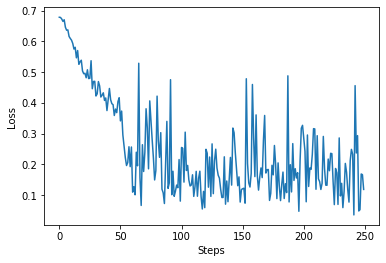

In [3]:
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.plot(step_loss)
plt.show()

A: 可以看到，由于网络比较浅，而且数据集较为简单，故UNet_shallow和UNet_add与原始UNet的性能并无太大差异。